Project #5: Video Stitching and Processing 

## CS445: Computational Photography

### Setup


In [1]:
import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

### Part I: Stitch two key frames 

#### This involves:
1. compute homography H between two frames (reference frame: 450); 
2. project each frame onto the same surface;
3. blend the surfaces.

Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image.

In [2]:
def score_projection(pt1, pt2):
  '''
  Score corresponding to the number of inliers for RANSAC
  Input: pt1 and pt2 are 2xN arrays of N points such that pt1[:, i] and pt2[:,i] should be close in Euclidean distance if they are inliers
  Outputs: score (scalar count of inliers) and inliers (1xN logical array)
  '''

  # TO DO
  threshold = 3
  score = 0
  inliers = np.zeros(pt1.shape[1], dtype=bool)
  for i in range(pt1.shape[1]):
    if np.linalg.norm(pt1[:,i] - pt2[:,i]) < threshold:
      score += 1
      inliers[i] = True

  return score, inliers

In [3]:
def auto_homography(Ia, Ib, homography_func=None, normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    # sift = cv2.xfeatures2d.SIFT_create()
    sift = cv2.SIFT_create() # for opencv 4.1.8
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0
    n_to_sample = 4 # Put the correct number of points here

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, n_to_sample, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        # print("numMatches: ", numMatches)
        # print("pts1: ", pts1)
        # print("pts2: ", pts2)
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)

        
        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        
        score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = inliers_t
    
    print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [4]:
def computeHomography(pts1, pts2,normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD. Normalization is optional.
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneoue coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    # TO DO
    if normalization_func is not None:
      pts1 = normalization_func(pts1)
      pts2 = normalization_func(pts2)
    
    # construct A matrix
    A = []
    for i in range(pts1.shape[1]):
        u1, v1 = pts1[0,i], pts1[1,i]
        u2, v2 = pts2[0,i], pts2[1,i]
        A.append([u1, v1, 1, 0, 0, 0, -u2*u1, -u2*v1, -u2])
        A.append([0, 0, 0, u1, v1, 1, -v2*u1, -v2*v1, -v2])
    A = np.array(A)
    
    # Apply SVD
    U, S, V = np.linalg.svd(A)
    
    # h is smallest singular value in V
    h = V[-1,:]
    H = h.reshape(3,3)
    
    return H


best score: 215.000000
[[-4.87983075e-03 -1.87720105e-04  1.00000000e+00]
 [-8.61665541e-05 -4.55017850e-03  7.61165598e-02]
 [-1.89731888e-06 -2.30847350e-07 -3.90850235e-03]]


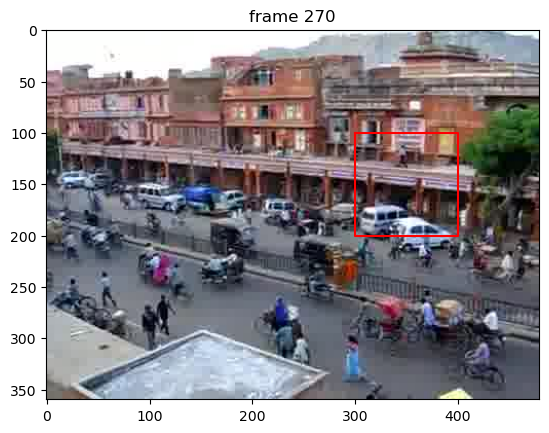

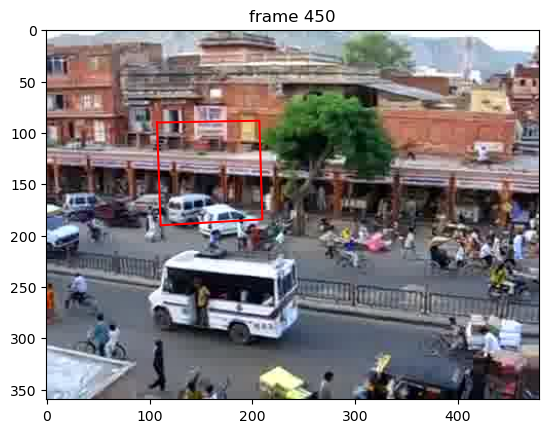

In [5]:
# images location
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

H = auto_homography(im1,im2, computeHomography)
print(H/H.max()) 

# plot the frames here
box_pts = np.array([[300, 400, 400, 300, 300], [100, 100, 200, 200, 100], [1, 1, 1, 1, 1]])
plt.figure()
plt.imshow(im1[:,:,[2,1,0]])
plt.plot(box_pts[0,:], box_pts[1, :], 'r-')
plt.title('frame 270')

# TO DO: project points into im2 and display the projected lines on im2
proj_box_pts = np.dot(H, box_pts)
proj_box_pts = proj_box_pts/proj_box_pts[2,:]
plt.figure()
plt.imshow(im2[:,:,[2,1,0]])
plt.plot(proj_box_pts[0,:], proj_box_pts[1, :], 'r-')
plt.title('frame 450')
plt.show()


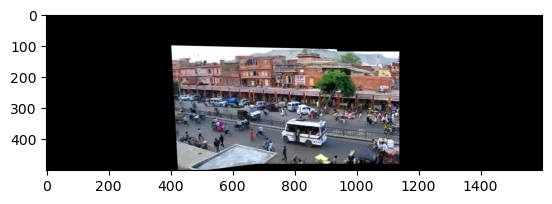

In [6]:
projectedWidth = 1600
projectedHeight = 500
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]], dtype=np.float32)

# TO DO: warp and blend the two images
im1_warped = cv2.warpPerspective(im1, np.dot(Tr, H), (projectedWidth, projectedHeight))
im2_warped = cv2.warpPerspective(im2, Tr, (projectedWidth, projectedHeight))
blendOut = utils.blendImages(im1_warped, im2_warped)

plt.figure()
plt.imshow(blendOut[:,:,[2,1,0]])
plt.show()


### Part II: Panorama using five key frames

Produce a panorama by mapping five key frames [90, 270, 450, 630, 810] onto the same reference frame 450.  


best score: 215.000000
best score: 213.000000
best score: 255.000000
best score: 149.000000


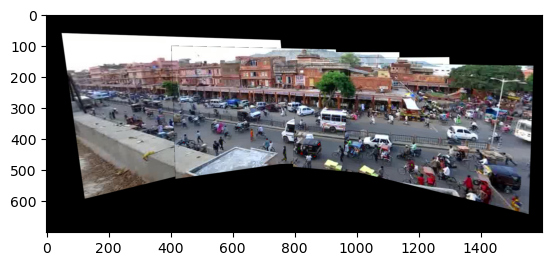

In [7]:
key_frames_idx = np.array([90, 270, 450, 630, 810])-1

frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
  frames[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3)))

### TO DO solution
projectedWidth = 1600
projectedHeight = 700
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]], dtype=np.float32)

homographies = [None] * 5
homographies[2] = np.eye(3) # reference frame
ref_frame = frames[2] # frame 450

# homographics for frames 270 and 630
homographies[1] = auto_homography(frames[1], ref_frame, computeHomography)
homographies[3] = auto_homography(frames[3], ref_frame, computeHomography)

# homographics for frames 90 and 810
# two stage mapping by using frame 270/630 as a guide
H_90_to_270 = auto_homography(frames[0], frames[1], computeHomography)
homographies[0] = np.dot(homographies[1], H_90_to_270)

H_810_to_630 = auto_homography(frames[4], frames[3], computeHomography)
homographies[4] = np.dot(homographies[3], H_810_to_630)

# warp and blend the frames
warped_frames = [None] * 5
for n in range(5):
  warped_frames[n] = cv2.warpPerspective(frames[n], np.dot(Tr, homographies[n]), (projectedWidth, projectedHeight))

# blend the frames
panorama = np.zeros((projectedHeight, projectedWidth, 3), dtype='uint8')
for n in range(5):
  panorama = utils.blendImages(panorama, warped_frames[n])

plt.figure()
plt.imshow(panorama[:,:,[2,1,0]])
plt.show()


### Part 3: Map the video to the reference plane

Project each frame onto the reference frame (using same size panorama) to create a video that shows the portion of the panorama revealed by each frame

In [8]:
# read all the images
import os 
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
  frames[idx] = cv2.imread(file_i)

In [9]:
print(len(frames))
print(frameCount)

900
900


In [12]:
### TO DO part 3 solution
# key frames
key_frames_idx = np.array([90, 270, 450, 630, 810])-1
key_homographies = homographies.copy() # homographies from part 2

# construct the homography for each frame
all_homographies = [None] * frameCount
for i in range(frameCount):
    if i in key_frames_idx:
        all_homographies[i] = key_homographies[np.where(key_frames_idx == i)[0][0]]
    else:
        # find the nearest key frame
        nearest_key_frame_idx = np.argmin(np.abs(key_frames_idx - i))
        nearest_key_frame = key_frames_idx[nearest_key_frame_idx]
        print("i: ", i, "; nearest_key_frame: ", nearest_key_frame+1)
        # compute the homography for the ith frame
        H_i_to_key = auto_homography(frames[i], frames[nearest_key_frame], computeHomography)
        all_homographies[i] = np.dot(key_homographies[nearest_key_frame_idx], H_i_to_key)

# save the all_homographies
np.save('all_homographies.npy', all_homographies)


i:  0 ; nearest_key_frame:  90
best score: 427.000000
i:  1 ; nearest_key_frame:  90
best score: 427.000000
i:  2 ; nearest_key_frame:  90
best score: 452.000000
i:  3 ; nearest_key_frame:  90
best score: 439.000000
i:  4 ; nearest_key_frame:  90
best score: 460.000000
i:  5 ; nearest_key_frame:  90
best score: 449.000000
i:  6 ; nearest_key_frame:  90
best score: 481.000000
i:  7 ; nearest_key_frame:  90
best score: 456.000000
i:  8 ; nearest_key_frame:  90
best score: 476.000000
i:  9 ; nearest_key_frame:  90
best score: 495.000000
i:  10 ; nearest_key_frame:  90
best score: 493.000000
i:  11 ; nearest_key_frame:  90
best score: 479.000000
i:  12 ; nearest_key_frame:  90
best score: 494.000000
i:  13 ; nearest_key_frame:  90
best score: 477.000000
i:  14 ; nearest_key_frame:  90
best score: 508.000000
i:  15 ; nearest_key_frame:  90
best score: 505.000000
i:  16 ; nearest_key_frame:  90
best score: 515.000000
i:  17 ; nearest_key_frame:  90
best score: 507.000000
i:  18 ; nearest_key

In [15]:
# warp the frames and save to output
projectedWidth = 2000
projectedHeight = 800
Tr = np.array([[1, 0, 700], [0, 1, 120], [0, 0, 1]], dtype=np.float32)

output_dir = 'images/output/frames'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in range(frameCount):
    warped_frame = cv2.warpPerspective(frames[i], np.dot(Tr, all_homographies[i]), (projectedWidth, projectedHeight))
    cv2.imwrite(os.path.join(output_dir, 'f{num}.jpg'.format(num=str(i+1).zfill(4))), warped_frame)

In [17]:
# make it video
(
    ffmpeg
    .input('images/output/frames/f%04d.jpg', framerate=30)
    .output('panorama.mp4')
    .run()
)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/baoyu/anaconda3/envs/dinov2 --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    

(None, None)

### Part 4: Create background panorama

Create a background panorama based on the result from Part 3.


In [ ]:
# TO DO part 4

### Part 5: Create background movie

Generate a movie that looks like the input movie but shows only background pixels. For each frame of the movie, you need to estimate a projection from the panorama to that frame. Your solution can use the background image you created in Part 4 and the per-frame homographies you created in Part 3. 


In [ ]:
# TO DO part 5



### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that emphasizes or includes only foreground pixels.

In [ ]:
# TO DO part 6


## Bells and whistles